In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns

2024-09-29 19:55:40.025979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 19:55:40.089014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 19:55:40.092741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 19:55:40.159107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 19:55:41.117199: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1727603742.218555   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603743.140178   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603743.142347   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")

data.head()

,timestamps,csi_len,channel,err_info,noise_floor,rate,bandWidth,num_tones,nr,nc,...,payload_length,block_length,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2
0,4170220887,560,2437,0,0,143,0,56,2,2,...,1320,1904,1,166.111408,80.056230,-1.376943,2.294327,0,6,2
1,4170220887,560,2437,0,0,143,0,56,2,2,...,1320,1904,2,168.866811,144.627107,2.816097,-0.513143,0,6,2
2,4170220887,560,2437,0,0,143,0,56,2,2,...,1320,1904,3,173.366663,86.052310,-1.373401,2.249167,0,6,2
3,4170220887,560,2437,0,0,143,0,56,2,2,...,1320,1904,4,172.409396,151.092687,2.792326,-0.534744,0,6,2
4,4170220887,560,2437,0,0,143,0,56,2,2,...,1320,1904,5,176.567268,89.196412,-1.400061,2.308611,0,6,2


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1727603756.576146   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603756.582104   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603756.586457   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603756.696596   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
variances = data.var()
print(variances)

low_variance_cols = variances[variances < 5e-3].index.tolist()
print("Columns with low or zero variance:")
print(low_variance_cols)

timestamps        1.929837e+18
csi_len           9.590696e+03
channel           2.805950e-03
err_info          4.619301e-03
noise_floor       0.000000e+00
rate              8.232657e+00
bandWidth         0.000000e+00
num_tones         0.000000e+00
nr                0.000000e+00
nc                1.223303e-01
rssi              7.971408e+00
rssi1             4.820231e+00
rssi2             1.001318e+01
rssi3             0.000000e+00
payload_length    1.846202e+04
block_length      2.814382e+04
subcarriers       2.612500e+02
ant1_amplitude    4.187203e+03
ant2_amplitude    5.506470e+03
ant1_phase        3.289260e+00
ant2_phase        3.291396e+00
with_receiver     0.000000e+00
coord1            3.996401e+00
coord2            2.251143e+00
dtype: float64
Columns with low or zero variance:
['channel', 'err_info', 'noise_floor', 'bandWidth', 'num_tones', 'nr', 'rssi3', 'with_receiver']


In [8]:
# Drop constant columns and timeframe from the DataFrame
data.drop(low_variance_cols, axis=1, inplace=True)
data.drop(['csi_len', 'rate', 'payload_length', 'block_length'], axis=1, inplace=True)
data.drop('timestamps', axis=1, inplace=True)
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,coord1,coord2
0,2,58,53,56,1,166.111408,80.056230,-1.376943,2.294327,6,2
1,2,58,53,56,2,168.866811,144.627107,2.816097,-0.513143,6,2
2,2,58,53,56,3,173.366663,86.052310,-1.373401,2.249167,6,2
3,2,58,53,56,4,172.409396,151.092687,2.792326,-0.534744,6,2
4,2,58,53,56,5,176.567268,89.196412,-1.400061,2.308611,6,2


In [9]:
# features_to_scale = ['csi_len', 'payload_length', 'block_length', 'ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
features_to_scale = ['ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
scaler = StandardScaler()

# Apply standardization on features
# data = data_cleaned.copy()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [10]:
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,coord1,coord2
0,2,-0.721583,-0.491469,-0.820802,1,-0.187897,-0.964817,-0.762717,1.268949,6,2
1,2,-0.721583,-0.491469,-0.820802,2,-0.145316,-0.094656,1.549240,-0.278531,6,2
2,2,-0.721583,-0.491469,-0.820802,3,-0.075775,-0.884014,-0.760765,1.244057,6,2
3,2,-0.721583,-0.491469,-0.820802,4,-0.090569,-0.007525,1.536134,-0.290437,6,2
4,2,-0.721583,-0.491469,-0.820802,5,-0.026314,-0.841644,-0.775465,1.276823,6,2


In [11]:
data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
data.drop('subcarriers', axis=1, inplace=True)
data.head()

,nc,rssi,rssi1,rssi2,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,coord1,coord2,...,subcarrier_47,subcarrier_48,subcarrier_49,subcarrier_50,subcarrier_51,subcarrier_52,subcarrier_53,subcarrier_54,subcarrier_55,subcarrier_56
0,2,-0.721583,-0.491469,-0.820802,-0.187897,-0.964817,-0.762717,1.268949,6,2,...,False,False,False,False,False,False,False,False,False,False
1,2,-0.721583,-0.491469,-0.820802,-0.145316,-0.094656,1.549240,-0.278531,6,2,...,False,False,False,False,False,False,False,False,False,False
2,2,-0.721583,-0.491469,-0.820802,-0.075775,-0.884014,-0.760765,1.244057,6,2,...,False,False,False,False,False,False,False,False,False,False
3,2,-0.721583,-0.491469,-0.820802,-0.090569,-0.007525,1.536134,-0.290437,6,2,...,False,False,False,False,False,False,False,False,False,False
4,2,-0.721583,-0.491469,-0.820802,-0.026314,-0.841644,-0.775465,1.276823,6,2,...,False,False,False,False,False,False,False,False,False,False


# Model

In [12]:
X = data.drop(columns=['coord1', 'coord2']) 
y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [13]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [14]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [15]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [16]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (7484064, 64)
Validation set shape: (2494688, 64)
Test set shape: (2494688, 64)


In [17]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # Hidden layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    
    # Output layer for regression (2 neurons for x and y coordinates)
    model.add(layers.Dense(2))  # For 2D localization, change to 3 for 3D localization

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1727603765.548924   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603765.550650   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727603765.551998   20544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,722 (73.13 KB)

 Trainable params: 18,722 (73.13 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=50, 
                        batch_size=512, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    # Evaluate the model on test data
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


2024-09-29 19:56:07.151566: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1915920384 exceeds 10% of free system memory.
2024-09-29 19:56:07.992306: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1915920384 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1727603769.745453   21040 service.cc:146] XLA service 0x7853a8002630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727603769.745475   21040 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-09-29 19:56:09.763788: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 19:56:10.001798: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-29 19:56:12.079099: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_384', 2504 bytes spill stores, 2504 bytes spill loads

2024-09-29 19:56:12.305512: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in 

   75/14618 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 9.7482 - mae: 2.5369    

I0000 00:00:1727603773.222120   21040 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14618/14618 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 2.9096 - mae: 1.4093 - val_loss: 2.5635 - val_mae: 1.3192
Epoch 2/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.5354 - mae: 1.3072 - val_loss: 2.4750 - val_mae: 1.2873
Epoch 3/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.4664 - mae: 1.2857 - val_loss: 2.4241 - val_mae: 1.2721
Epoch 4/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.4140 - mae: 1.2701 - val_loss: 2.3902 - val_mae: 1.2641
Epoch 5/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.3807 - mae: 1.2587 - val_loss: 2.3589 - val_mae: 1.2539
Epoch 6/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.3598 - mae: 1.2515 - val_loss: 2.3580 - val_mae: 1.2539
Epoch 7/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.3407 - mae: 1.2452 - val_loss: 2.3244 - val_mae: 1.2403
Epoch 8/50
14618/14618 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 2.3228 - mae: 1.2389 - val_loss: 2.3151 - val_mae: 1.2383
Epoch 9/50
14618/14618 ━━━━

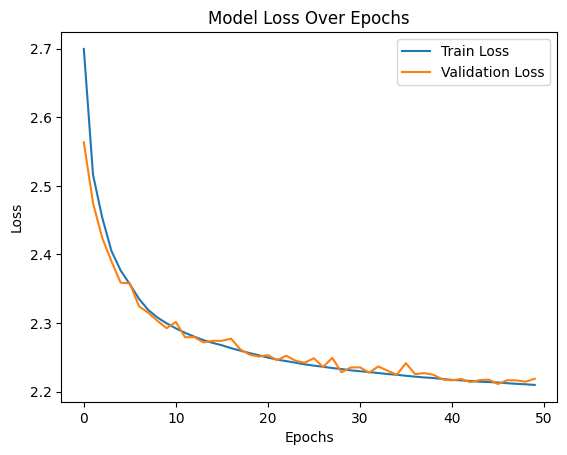

In [19]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# After training your model
y_pred = model.predict(X_test)

77959/77959 ━━━━━━━━━━━━━━━━━━━━ 42s 537us/step


In [21]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [22]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.2164
Mean Relative Error for coord2: 0.2213


In [23]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.5489
Spearman's Rank Correlation for coord2: 0.3054


In [24]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Filter out predictions that don't map to a valid label
valid_indices = y_pred_labels != -1
accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
print(f"Classification Accuracy: {accuracy:.4f}")


Classification Accuracy: nan


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:148: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)
/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)


ValueError: zero-size array to reduction operation maximum which has no identity

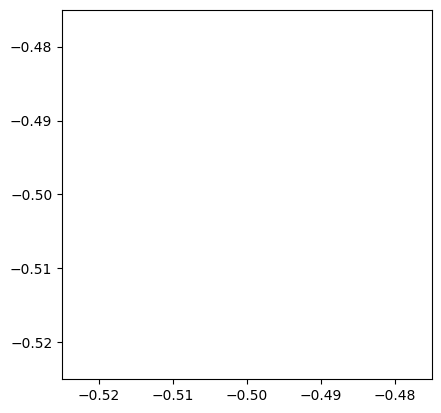

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of Predicted vs Actual Classes')
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.7310


In [33]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerance = 1  # Adjust based on your coordinate system
accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
print(f"Custom Accuracy within tolerance {tolerance}: {accuracy:.4f}")


Custom Accuracy within tolerance 1: 0.2420


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


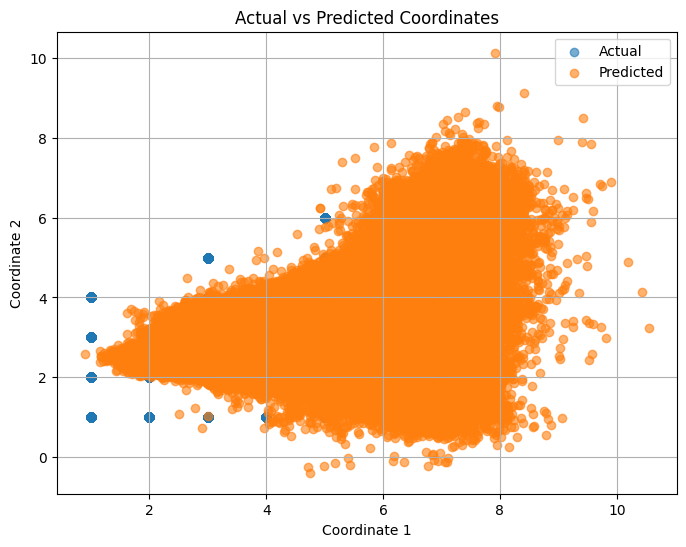

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # Calculate MAE
# test_mae = np.mean(np.abs(y_test - y_pred), axis=0)
# # print(f"Test MAE: {test_mae}")
# print(f"Mean Absolute Error for coord1: {test_mae[0]:.4f}")
# print(f"Mean Absolute Error for coord2: {test_mae[1]:.4f}")

# # Calculate RMSE

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Test RMSE: {rmse}")
# rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
# rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))
# print(f"RMSE for coord1: {rmse_coord1:.4f}")
# print(f"RMSE for coord2: {rmse_coord2:.4f}")

# # Calculate Mean Distance Error
# distance_errors = np.linalg.norm(y_test - y_pred, axis=1)
# mean_distance_error = np.mean(distance_errors)
# print(f"Mean Distance Error: {mean_distance_error}")

# # Plot CDF of Localization Error
# sorted_errors = np.sort(distance_errors)
# cdf = np.arange(len(sorted_errors)) / float(len(sorted_errors))
# plt.plot(sorted_errors, cdf)
# plt.xlabel('Localization Error (units)')
# plt.ylabel('Cumulative Probability')
# plt.title('CDF of Localization Error')
# plt.grid(True)
# plt.show()

In [ ]:
# import numpy as np

# # Check for NaNs in y_test and y_pred
# print("NaNs in y_test:", np.isnan(y_test).any())
# print("NaNs in y_pred:", np.isnan(y_pred).any())

# # Check for Infs in y_test and y_pred
# print("Infs in y_test:", np.isinf(y_test).any())
# print("Infs in y_pred:", np.isinf(y_pred).any())


In [ ]:
# print("y_test min:", np.min(y_test, axis=0))
# print("y_test max:", np.max(y_test, axis=0))

# print("y_pred min:", np.min(y_pred, axis=0))
# print("y_pred max:", np.max(y_pred, axis=0))


In [ ]:


# # # Optionally, clip negative predictions if they are not valid in your context
# # y_pred_np = np.clip(y_pred_np, a_min=1, a_max=None)

# # Recalculate R-squared score
# r2 = r2_score(y_test_np, y_pred_np)
# print(f"R-squared Score: {r2}")

# # Calculate R-squared for each coordinate
# r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
# r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

# print(f"R-squared for coord1: {r2_coord1:.4f}")
# print(f"R-squared for coord2: {r2_coord2:.4f}")

In [ ]:
# r2 = r2_score(y_test, y_pred)
# print(f"R-squared Score: {r2}")

In [ ]:
# plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.5)
# plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.5)
# plt.xlabel('Coordinate 1')
# plt.ylabel('Coordinate 2')
# plt.title('Predicted vs. Actual Coordinates')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:


# error_vectors = y_pred_np - y_test_np
# plt.quiver(y_test_np[:, 0], y_test_np[:, 1], error_vectors[:, 0], error_vectors[:, 1], angles='xy', scale_units='xy', scale=1)
# plt.xlabel('Coordinate 1')
# plt.ylabel('Coordinate 2')
# plt.title('Error Vectors from Actual to Predicted Coordinates')
# plt.grid(True)
# plt.show()


In [ ]:
# thresholds = [0.5, 1.0, 1.5, 2.0, 3.0]  # Adjust based on acceptable error units
# for thresh in thresholds:
#     within_thresh = np.mean(distance_errors <= thresh) * 100
#     print(f"Percentage within {thresh} units: {within_thresh:.2f}%")


In [ ]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5)
# mae_scores = []

# for train_index, test_index in kf.split(X):
#     X_train_cv, X_test_cv = X[train_index], X[test_index]
#     y_train_cv, y_test_cv = y[train_index], y[test_index]

#     # Train the model
#     model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=128, verbose=0)

#     # Evaluate
#     y_pred_cv = model.predict(X_test_cv)
#     mae_cv = np.mean(np.abs(y_test_cv - y_pred_cv))
#     mae_scores.append(mae_cv)

# print(f"Cross-validated MAE: {np.mean(mae_scores)}")
